In [57]:
import pandas as pd
import numpy as np
import math

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix #Importamos la matriz de confusión
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [58]:
tr = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Check the data

In [59]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [60]:
tr.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


In [61]:
tr.isnull().sum()

model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
price           0
dtype: int64

In [62]:
variablescategoricas=['model', 'motor_type', 'wheel', 'color', 'type', 'status']
for i in tr[variablescategoricas]: # bucle para todas las columnas del dataframe
    print(i)
    print('Categorías:')
    print(tr[i].value_counts())
    print()

model
Categorías:
model
mercedes-benz    402
hyundai          351
nissan           350
kia              285
toyota           254
Name: count, dtype: int64

motor_type
Categorías:
motor_type
petrol            1420
gas                165
petrol and gas      54
diesel               2
hybrid               1
Name: count, dtype: int64

wheel
Categorías:
wheel
left    1642
Name: count, dtype: int64

color
Categorías:
color
black      541
white      407
silver     223
gray       189
blue       141
red         47
other       30
cherry      20
green       10
brown       10
golden       6
orange       5
beige        5
clove        3
purple       2
skyblue      2
pink         1
Name: count, dtype: int64

type
Categorías:
type
sedan                1276
suv                   301
Universal              37
hatchback              15
Coupe                  11
pickup                  1
minivan / minibus       1
Name: count, dtype: int64

status
Categorías:
status
excellent    1200
good          334
norma

## Data transformations

We see that the running column is categorical and is given in miles and kilometers, therefore we will transform it so that it is numerical and is all in kilometers

In [63]:
# Función para convertir los valores a kilómetros
def convertir_a_km(valor):
    valor_num = float(valor.split()[0])  # Extrae el valor numérico
    unidad = valor.split()[1]  # Extrae la unidad
    if unidad == 'miles':
        valor_num *= 1.60934  # Convierte de millas a kilómetros
    return valor_num

# Aplica la función a la columna 'distancia'
tr['running_Km'] = tr['running'].apply(convertir_a_km)
test['running_Km'] = test['running'].apply(convertir_a_km)

# Convierte la columna 'distancia_km' a tipo float
tr['running_Km'] = tr['running_Km'].astype(float)
test['running_Km'] = test['running'].apply(convertir_a_km)

In [64]:
tr=tr.drop('running', axis=1)
test=test.drop('running', axis=1)

In [65]:
# Insertar la columna 'distancia_km' en la posición 4
tr.insert(4, 'Running_Km', tr['running_Km'])
tr = tr.drop('running_Km', axis=1)

test.insert(4, 'Running_Km', test['running_Km'])
test = test.drop('running_Km', axis=1)

We have also appreciated that the variable wheel only has one category, therefore it does not provide us with information and we can eliminate it.

In [66]:
tr = tr.drop('wheel', axis=1)
test = test.drop('wheel', axis=1)
tr.head()

,model,year,motor_type,Running_Km,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000.00,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000.00,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,152887.30,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,220479.58,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000.00,black,sedan,good,2.0,26000


## Feature selection

We build a correlation matrix between the variables to see which of them have a lower correlation with the variable to be predicted 'price' and thus be able to discard them from our model.

<Axes: >

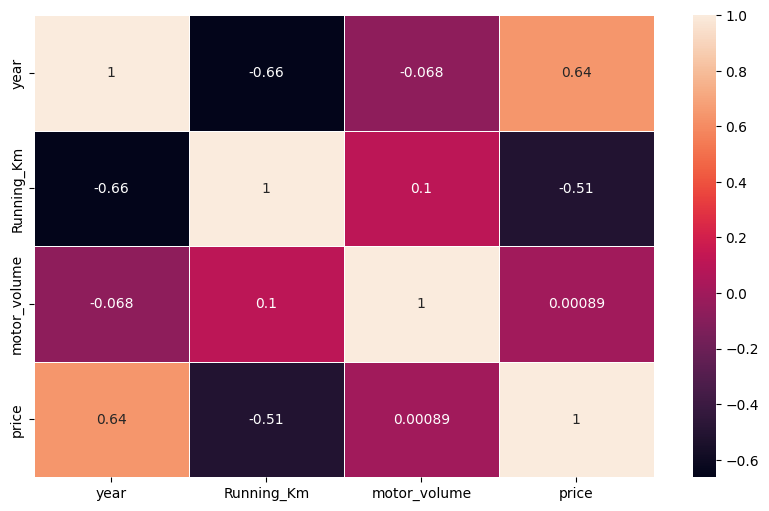

In [67]:
numerical_features = tr.select_dtypes(exclude = 'object').columns
plt.figure(figsize = (10,6))
sns.heatmap(data = tr[numerical_features].corr(), annot = True, linewidth = 0.5)

It can be seen that the variable motor_volume has a very low correlation with the variable to be predicted price and therefore we can eliminate it.

We can observe this low linearity between both in the following graph.

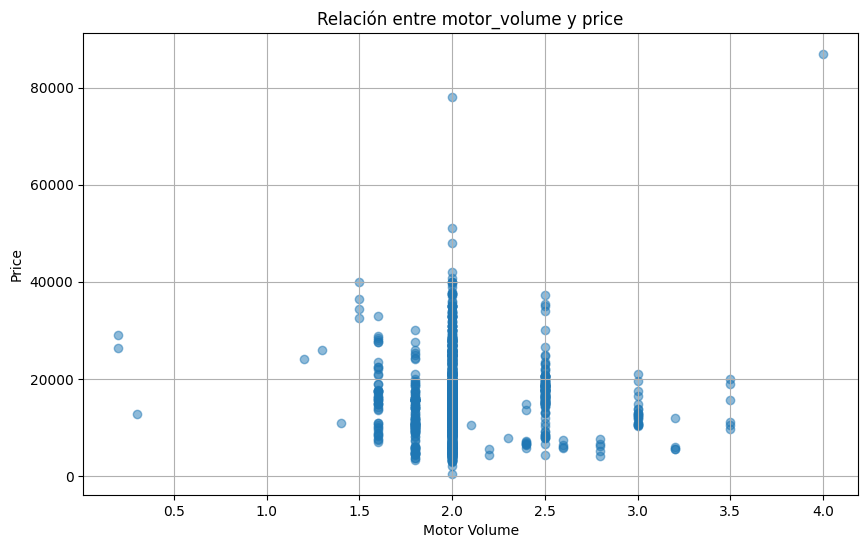

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(tr['motor_volume'], tr['price'], alpha=0.5)  # alpha es la transparencia de los puntos
plt.title('Relación entre motor_volume y price')
plt.xlabel('Motor Volume')
plt.ylabel('Price')
plt.grid(True)
plt.show()

We will eliminate this variable from both the train and test data sets

In [69]:
X = tr.drop(['price'], axis=1)

y = tr['price']

In [70]:
df = pd.concat([X, test], ignore_index=True)
df = df.drop(['Id'], axis=1)
df = df.drop(['motor_volume'], axis=1)
df.head()

,model,year,motor_type,Running_Km,color,type,status
0,toyota,2022,petrol,3000.00,skyblue,sedan,excellent
1,mercedes-benz,2014,petrol,132000.00,black,sedan,excellent
2,kia,2018,petrol,152887.30,other,sedan,excellent
3,mercedes-benz,2002,petrol,220479.58,golden,sedan,excellent
4,mercedes-benz,2017,petrol,130000.00,black,sedan,good


## Standardization and coding

In [71]:
from sklearn.preprocessing import StandardScaler

col_num = ['year', 'Running_Km']

df_stand = StandardScaler().fit_transform(df[col_num])
df_stand = pd.DataFrame(df_stand, columns=col_num)

# Combinar las columnas estandarizadas con las no estandarizadas
# Esto es opcional y depende de tus necesidades
df_stand = pd.concat([df.drop(columns=col_num), df_stand], axis=1)
df_stand

,model,motor_type,color,type,status,year,Running_Km
0,toyota,petrol,skyblue,sedan,excellent,1.089387,-1.219648
1,mercedes-benz,petrol,black,sedan,excellent,-0.127348,0.143034
2,kia,petrol,other,sedan,excellent,0.481019,0.363676
3,mercedes-benz,petrol,golden,sedan,excellent,-1.952452,1.077682
4,mercedes-benz,petrol,black,sedan,good,0.328928,0.121907
...,...,...,...,...,...,...,...
2048,nissan,petrol,black,suv,excellent,0.937295,-0.898520
2049,hyundai,petrol,other,sedan,excellent,0.328928,-0.231330
2050,mercedes-benz,petrol,white,sedan,good,-0.431532,1.051489
2051,kia,petrol,red,sedan,good,0.785203,-0.571333


For the encoding of categorical variables we will use one hot encoding.

In [72]:
from sklearn.preprocessing import OrdinalEncoder
df_encod = pd.get_dummies(df_stand) # variables categóricas en variables dummy o indicadoras, estás creando una representación de tipo "one-hot encoding"
df_encod

,year,Running_Km,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_diesel,motor_type_gas,motor_type_hybrid,...,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal
0,1.089387,-1.219648,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,-0.127348,0.143034,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
2,0.481019,0.363676,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,-1.952452,1.077682,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
4,0.328928,0.121907,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048,0.937295,-0.898520,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
2049,0.328928,-0.231330,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
2050,-0.431532,1.051489,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2051,0.785203,-0.571333,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


## CatBoostRegressor Model

In [73]:
X_train = df_encod.iloc[:len(X)]
X_test = df_encod.iloc[len(X):]

Using scikit-learn's GridSearchCV along with CatBoost's CatBoostRegressor we performed a search for the best hyperparameters for a CatBoost regression model.

In [74]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

Niterations = [100, 250, 300]
learningRate = [0.025, 0.035, 0.05]

param_grid = {'iterations': Niterations, 'learning_rate': learningRate}

catboost_reg = CatBoostRegressor(random_seed=0, depth=6, loss_function='RMSE', verbose=False)

grid = GridSearchCV(estimator=catboost_reg, param_grid=param_grid, cv=5, n_jobs=-1)

grid.fit(X_train, y)

print("Best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best mean cross-validation score: 0.758
Best parameters: {'iterations': 250, 'learning_rate': 0.035}


As this is part of a Kaggle competition and we do not have the 'y' values in the test sample, to make an estimate of how good our model is we will divide the training sample into training and test to get an idea approximate metrics.

In [75]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y, test_size=0.3, random_state=42)

In [76]:
catboost_reg = CatBoostRegressor(random_seed=0, depth=6, learning_rate=0.035, iterations=250, loss_function='RMSE', verbose=False)
catboost_reg.fit(X_train2, y_train2)

y_pred2 = catboost_reg.predict(X_test2)

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test2, y_pred2)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(y_test2, y_pred2)
print("R² Score:", r2)

Mean Squared Error: 9814591.84872369
Root Mean Squared Error: 3132.824899148321
R² Score: 0.7784732545710966


Considering these metrics are pretty good we can create the 'y' variables for the original test sample. This will be what will finally be uploaded to Kaggle.

In [78]:
catboost_reg = CatBoostRegressor(random_seed=0, depth=6, learning_rate=0.035, iterations=250, loss_function='RMSE', verbose=False)
catboost_reg.fit(X_train, y)

y_pred = catboost_reg.predict(X_test)

In [ ]:
submission = pd.DataFrame({'Id': range(len(y_pred)), 'price': y_pred})
submission.to_csv('predictions.csv', index=False)